<a href="https://colab.research.google.com/github/tameemglewo/Intrusion-Detection-System-using-Machine-Learning/blob/main/Multi_Class_Intrusion_Detection_System_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Multi-Class Attack Classifier
This script processes the CIC-IDS2017 dataset to classify the specific type
of network attack, after excluding all benign traffic.
"""

import pandas as pd
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import time

# --- Mount Google Drive ---
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"Error mounting drive: {e}")

# --- 1. Data Loading and Initial Cleaning ---
print("\n--- Loading Data ---")
data_dir = '/content/drive/MyDrive/CICIDS2017_Parquet/'

if not os.path.exists(data_dir):
    print(f"Error: Directory not found at {data_dir}. Please check your Google Drive path.")
    exit()

print("Loading and concatenating Parquet files...")
all_parquet_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.parquet')]
dfs = [pd.read_parquet(file) for file in all_parquet_files]
full_dataset = pd.concat(dfs, ignore_index=True)
print(f"Full dataset loaded. Initial shape: {full_dataset.shape}")

# Basic Cleaning
# --- Track and report the number of cleaned rows ---
print("\n--- Cleaning Data ---")
initial_rows = full_dataset.shape[0]

# Strip column names
full_dataset.columns = full_dataset.columns.str.strip()

# Handle infinite values
full_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
rows_before_na_drop = full_dataset.shape[0]
full_dataset.dropna(inplace=True)
rows_after_na_drop = full_dataset.shape[0]
print(f"Removed {rows_before_na_drop - rows_after_na_drop} rows with NaN or infinite values.")

# Handle duplicate rows
rows_before_dup_drop = full_dataset.shape[0]
full_dataset.drop_duplicates(inplace=True)
rows_after_dup_drop = full_dataset.shape[0]
print(f"Removed {rows_before_dup_drop - rows_after_dup_drop} duplicate rows.")

# Handle single-value columns
columns_to_drop_single_value = [col for col in full_dataset.columns if full_dataset[col].nunique() <= 1]
if columns_to_drop_single_value:
    full_dataset.drop(columns=columns_to_drop_single_value, inplace=True)
    print(f"Removed {len(columns_to_drop_single_value)} columns with a single unique value.")

final_rows = full_dataset.shape[0]
print(f"\nTotal rows cleaned: {initial_rows - final_rows}")
print(f"Dataset cleaned. Final shape: {full_dataset.shape}")

Mounted at /content/drive

--- Loading Data ---
Loading and concatenating Parquet files...
Full dataset loaded. Initial shape: (2313810, 78)

--- Cleaning Data ---
Removed 0 rows with NaN or infinite values.
Removed 82004 duplicate rows.
Removed 8 columns with a single unique value.

Total rows cleaned: 82004
Dataset cleaned. Final shape: (2231806, 70)


In [ ]:
# --- 2. Prepare Data for Attack-Only Classification ---
print("\n--- Preparing Data for Multi-Class Attack Classification ---")

# Filter out 'Benign' traffic
# Create a copy that only contains attack data.
# The label might be 'Benign' or 'BENIGN'. We check for both.
attack_df = full_dataset[~full_dataset['Label'].str.contains('Benign', case=False)].copy()

if attack_df.empty:
    print("Error: No attack data found after filtering.")
    exit()

# *** MODIFICATION: Consolidate all web attack types into a single category ***
print("\nConsolidating web attack categories...")
attack_df['Label'] = attack_df['Label'].replace({
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Web Attack � Brute Force': 'Web Attack'
})
print("Web attacks consolidated.")

print(f"Filtered out benign traffic. Remaining data shape: {attack_df.shape}")
print("\nDistribution of remaining traffic (attack types):")
print(attack_df['Label'].value_counts())


--- Preparing Data for Multi-Class Attack Classification ---

Consolidating web attack categories...
Web attacks consolidated.
Filtered out benign traffic. Remaining data shape: (336492, 70)

Distribution of remaining traffic (attack types):
Label
DoS Hulk            172846
DDoS                128014
DoS GoldenEye        10286
FTP-Patator           5931
DoS slowloris         5385
DoS Slowhttptest      5228
SSH-Patator           3219
Web Attack            2143
PortScan              1956
Bot                   1437
Infiltration            36
Heartbleed              11
Name: count, dtype: int64


In [ ]:
# --- 3. Feature Engineering and Label Encoding for Attacks ---
# Use LabelEncoder to convert string attack labels to integers
label_encoder = LabelEncoder()
attack_df['Label_Encoded'] = label_encoder.fit_transform(attack_df['Label'])

# Store the mapping for later interpretation
num_classes = len(label_encoder.classes_)
print(f"\nEncoded {num_classes} attack types into numerical format.")
print("Attack Class to integer mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  '{class_name}': {i}")

# Separate features (X) from the encoded label (y)
X = attack_df.drop(['Label', 'Label_Encoded'], axis=1)
y = attack_df['Label_Encoded']

# Apply Min-Max Scaling to numerical features
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
scaler = MinMaxScaler()
X_scaled = X.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X_scaled[numerical_cols])
print("\nNumerical features scaled using MinMaxScaler.")


Encoded 12 attack types into numerical format.
Attack Class to integer mapping:
  'Bot': 0
  'DDoS': 1
  'DoS GoldenEye': 2
  'DoS Hulk': 3
  'DoS Slowhttptest': 4
  'DoS slowloris': 5
  'FTP-Patator': 6
  'Heartbleed': 7
  'Infiltration': 8
  'PortScan': 9
  'SSH-Patator': 10
  'Web Attack': 11

Numerical features scaled using MinMaxScaler.


In [ ]:
# --- 4. Stratified Sampling ---
# We sample a fraction of the data to make training manageable.
target_sample_size = 200000 # Adjusted sample size for the smaller dataset
if len(X_scaled) > target_sample_size:
    print(f"\n--- Performing Stratified Sampling to get {target_sample_size} samples ---")
    sss = StratifiedShuffleSplit(n_splits=1, train_size=target_sample_size, random_state=42)
    for train_index, _ in sss.split(X_scaled, y):
        X_sampled = X_scaled.iloc[train_index]
        y_sampled = y.iloc[train_index]
    print(f"Sampling complete. Sampled data shape: {X_sampled.shape}")
    # MODIFICATION: Show class distribution after sampling
    print(f"\nClass distribution AFTER stratified sampling:\n{y_sampled.value_counts().sort_index()}")
else:
    print("\nDataset is smaller than target sample size, skipping sampling.")
    X_sampled = X_scaled
    y_sampled = y


--- Performing Stratified Sampling to get 200000 samples ---
Sampling complete. Sampled data shape: (200000, 69)

Class distribution AFTER stratified sampling:
Label_Encoded
0        854
1      76087
2       6114
3     102734
4       3107
5       3201
6       3525
7          7
8         21
9       1163
10      1913
11      1274
Name: count, dtype: int64


In [ ]:
# --- 5. Outlier Detection ---
# *** MODIFICATION: Implemented robust outlier detection to preserve rare classes ***
print("\n--- Starting Intelligent Outlier Removal using LOF ---")
# Define a threshold for rare classes (do not apply LOF to these)
RARE_CLASS_THRESHOLD = 100
class_counts = y_sampled.value_counts()
majority_classes = class_counts[class_counts >= RARE_CLASS_THRESHOLD].index
minority_classes = class_counts[class_counts < RARE_CLASS_THRESHOLD].index

# Separate majority and minority data
X_majority = X_sampled[y_sampled.isin(majority_classes)]
y_majority = y_sampled[y_sampled.isin(majority_classes)]
X_minority = X_sampled[y_sampled.isin(minority_classes)]
y_minority = y_sampled[y_sampled.isin(minority_classes)]

print(f"Separated data: {len(X_majority)} majority samples, {len(X_minority)} rare minority samples.")

# Apply LOF only to the majority class data
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, n_jobs=-1)
outlier_predictions = lof.fit_predict(X_majority)
X_majority_cleaned = X_majority[outlier_predictions == 1]
y_majority_cleaned = y_majority[outlier_predictions == 1]
print(f"Removed {(outlier_predictions == -1).sum()} outliers.")

# Recombine the cleaned majority data with the untouched minority data
X_cleaned = pd.concat([X_majority_cleaned, X_minority]).reset_index(drop=True)
y_cleaned = pd.concat([y_majority_cleaned, y_minority]).reset_index(drop=True)
print(f"Final Features shape after intelligent LOF: {X_cleaned.shape}")
print(f"Final class distribution BEFORE SPLIT:\n{y_cleaned.value_counts().sort_index()}")


--- Starting Intelligent Outlier Removal using LOF ---
Separated data: 199972 majority samples, 28 rare minority samples.
Removed 9999 outliers.
Final Features shape after intelligent LOF: (190001, 69)
Final class distribution BEFORE SPLIT:
Label_Encoded
0       727
1     74364
2      5533
3     96138
4      2859
5      2906
6      3351
7         7
8        21
9      1057
10     1825
11     1213
Name: count, dtype: int64


In [ ]:
# --- 6. Preparing Data for Multi-Class Model ---
# Using standard stratified split now that we've protected the rare classes
print(f"Final class distribution BEFORE SPLIT:\n{y_cleaned.value_counts().sort_index()}")
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.3, random_state=42, stratify=y_cleaned
)
print("\n--- Standard Stratified Train-Test Split Complete ---")

# Check shapes before and after SMOTE ---
print("\n--- Handling Class Imbalance (SMOTE) on Training Data ---")
print(f"\nShape of training data BEFORE SMOTE: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Class distribution AFTER SPLIT & BEFORE SMOTE:\n{y_train.value_counts().sort_index()}")

# --- 7. Applying SMOTE on Training Data ---
min_train_class_count = y_train.value_counts().min()
if min_train_class_count > 1:
    smote = SMOTE(random_state=42, k_neighbors=min_train_class_count - 1)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print("\nSMOTE applied successfully.")
    print(f"\nShape of training data AFTER SMOTE: X_train_resampled: {X_train_resampled.shape}, y_train_resampled: {y_train_resampled.shape}")
    print(f"Class distribution AFTER SMOTE:\n{pd.Series(y_train_resampled).value_counts().sort_index()}")
else:
    print("\nCannot apply SMOTE, at least one class has only 1 sample. Training on imbalanced data.")
    X_train_resampled, y_train_resampled = X_train, y_train

Final class distribution BEFORE SPLIT:
Label_Encoded
0       727
1     74364
2      5533
3     96138
4      2859
5      2906
6      3351
7         7
8        21
9      1057
10     1825
11     1213
Name: count, dtype: int64

--- Standard Stratified Train-Test Split Complete ---

--- Handling Class Imbalance (SMOTE) on Training Data ---

Shape of training data BEFORE SMOTE: X_train: (133000, 69), y_train: (133000,)
Class distribution AFTER SPLIT & BEFORE SMOTE:
Label_Encoded
0       509
1     52055
2      3873
3     67296
4      2001
5      2034
6      2346
7         5
8        15
9       740
10     1277
11      849
Name: count, dtype: int64

SMOTE applied successfully.

Shape of training data AFTER SMOTE: X_train_resampled: (807552, 69), y_train_resampled: (807552,)
Class distribution AFTER SMOTE:
Label_Encoded
0     67296
1     67296
2     67296
3     67296
4     67296
5     67296
6     67296
7     67296
8     67296
9     67296
10    67296
11    67296
Name: count, dtype: int64


In [ ]:
# --- 8. Building and Training the CNN Model for Attacks ---
X_train_reshaped = X_train_resampled.values.reshape(-1, X_train_resampled.shape[1], 1)
X_test_reshaped = X_test.values.reshape(-1, X_test.shape[1], 1)
y_train_np = y_train_resampled.values
y_test_np = y_test.values

input_shape = (X_train_reshaped.shape[1], 1)
model = Sequential([
    # First Convolutional Layer
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.3), # Helps prevent overfitting

    # Second Convolutional Layer
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    # Flatten the output to feed into Dense layers
    Flatten(),

    # Fully Connected (Dense) Layers
    Dense(128, activation='relu'),
    Dropout(0.5), # More aggressive dropout for the dense layer

    # Output Layer for Binary Classification
    # 12 neurons with 'softmax' activation outputs a probability distribution between attack types that adds up to 100%
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

print("\n--- Training the Multi-Class Attack Classifier ANN Model ---")

start_time = time.time()

# EarlyStopping: Stops training if validation loss doesn't improve for 'patience' epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint: Saves the best model weights based on a monitored metric
model_checkpoint = ModelCheckpoint('best_ann_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train_reshaped, y_train_np,
    epochs=50, # Max epochs, but EarlyStopping will likely stop it sooner
    batch_size=64, # Adjust batch size based on memory/speed
    validation_split=0.2, # Use 20% of the (resampled) training data for validation
    callbacks=[early_stopping, model_checkpoint],
    verbose=1 # Show training progress
)
end_time = time.time()
print(f"\nANN model training complete in {end_time - start_time:.2f} seconds.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 67, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 31, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,396 (1.04 MB)

 Trainable params: 272,396 (1.04 MB)

 Non-trainable params: 0 (0.00 B)


--- Training the Multi-Class Attack Classifier ANN Model ---
Epoch 1/50
10095/10095 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9209 - loss: 0.2530

10095/10095 ━━━━━━━━━━━━━━━━━━━━ 229s 22ms/step - accuracy: 0.9209 - loss: 0.2530 - val_accuracy: 0.9220 - val_loss: 0.4111
Epoch 2/50
10095/10095 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9887 - loss: 0.0388

10095/10095 ━━━━━━━━━━━━━━━━━━━━ 259s 22ms/step - accuracy: 0.9887 - loss: 0.0388 - val_accuracy: 0.9499 - val_loss: 0.1901
Epoch 3/50
10094/10095 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9916 - loss: 0.0284

10095/10095 ━━━━━━━━━━━━━━━━━━━━ 272s 23ms/step - accuracy: 0.9916 - loss: 0.0284 - val_accuracy: 0.9738 - val_loss: 0.1336
Epoch 4/50
10094/10095 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9929 - loss: 0.0242

10095/10095 ━━━━━━━━━━━━━━━━━━━━ 253s 22ms/step - accuracy: 0.9929 - loss: 0.0242 - val_accuracy: 0.9583 - val_loss: 0.1301
Epoch 5/50
10093/10095 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9937 - loss: 0.0209

10095/10095 ━━━━━━━━━━━━━━━━━━━━ 262s 22ms/step - accuracy: 0.9937 - loss: 0.0209 - val_accuracy: 0.9775 - val_loss: 0.0811
Epoch 6/50
10095/10095 ━━━━━━━━━━━━━━━━━━━━ 268s 23ms/step - accuracy: 0.9940 - loss: 0.0198 - val_accuracy: 0.9739 - val_loss: 0.0853
Epoch 7/50
10095/10095 ━━━━━━━━━━━━━━━━━━━━ 223s 22ms/step - accuracy: 0.9946 - loss: 0.0181 - val_accuracy: 0.9776 - val_loss: 0.1036
Epoch 8/50
10094/10095 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9951 - loss: 0.0173

10095/10095 ━━━━━━━━━━━━━━━━━━━━ 237s 24ms/step - accuracy: 0.9951 - loss: 0.0173 - val_accuracy: 0.9743 - val_loss: 0.0613
Epoch 9/50
10094/10095 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9954 - loss: 0.0155

10095/10095 ━━━━━━━━━━━━━━━━━━━━ 236s 23ms/step - accuracy: 0.9954 - loss: 0.0155 - val_accuracy: 0.9719 - val_loss: 0.0589
Epoch 10/50
10095/10095 ━━━━━━━━━━━━━━━━━━━━ 226s 22ms/step - accuracy: 0.9954 - loss: 0.0155 - val_accuracy: 0.9739 - val_loss: 0.0680
Epoch 11/50
10095/10095 ━━━━━━━━━━━━━━━━━━━━ 222s 22ms/step - accuracy: 0.9957 - loss: 0.0149 - val_accuracy: 0.9739 - val_loss: 0.0674
Epoch 12/50
10095/10095 ━━━━━━━━━━━━━━━━━━━━ 230s 23ms/step - accuracy: 0.9956 - loss: 0.0153 - val_accuracy: 0.9819 - val_loss: 0.0690
Epoch 13/50
10095/10095 ━━━━━━━━━━━━━━━━━━━━ 265s 23ms/step - accuracy: 0.9959 - loss: 0.0141 - val_accuracy: 0.9741 - val_loss: 0.0658
Epoch 14/50
10095/10095 ━━━━━━━━━━━━━━━━━━━━ 226s 22ms/step - accuracy: 0.9958 - loss: 0.0146 - val_accuracy: 0.9788 - val_loss: 0.0705
Epoch 15/50
10095/10095 ━━━━━━━━━━━━━━━━━━━━ 261s 22ms/step - accuracy: 0.9959 - loss: 0.0146 - val_accuracy: 0.9787 - val_loss: 0.0637
Epoch 16/50
10095/10095 ━━━━━━━━━━━━━━━━━━━━ 264s 23ms/step 


--- Model Evaluation on Test Set ---
Test Loss: 0.0138
Test Accuracy: 0.9985
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step

--- Classification Report ---
                  precision    recall  f1-score   support

             Bot    0.97758   1.00000   0.98866       218
            DDoS    1.00000   0.99973   0.99987     22309
   DoS GoldenEye    0.98633   1.00000   0.99312      1660
        DoS Hulk    0.99958   0.99917   0.99938     28842
DoS Slowhttptest    0.99766   0.99417   0.99591       858
   DoS slowloris    0.99315   0.99771   0.99542       872
     FTP-Patator    1.00000   0.99900   0.99950      1005
      Heartbleed    1.00000   1.00000   1.00000         2
    Infiltration    1.00000   1.00000   1.00000         6
        PortScan    1.00000   0.96530   0.98234       317
     SSH-Patator    1.00000   0.93978   0.96896       548
      Web Attack    0.91206   0.99725   0.95276       364

        accuracy                        0.99854     57001
       macro avg    0.98886   0.99

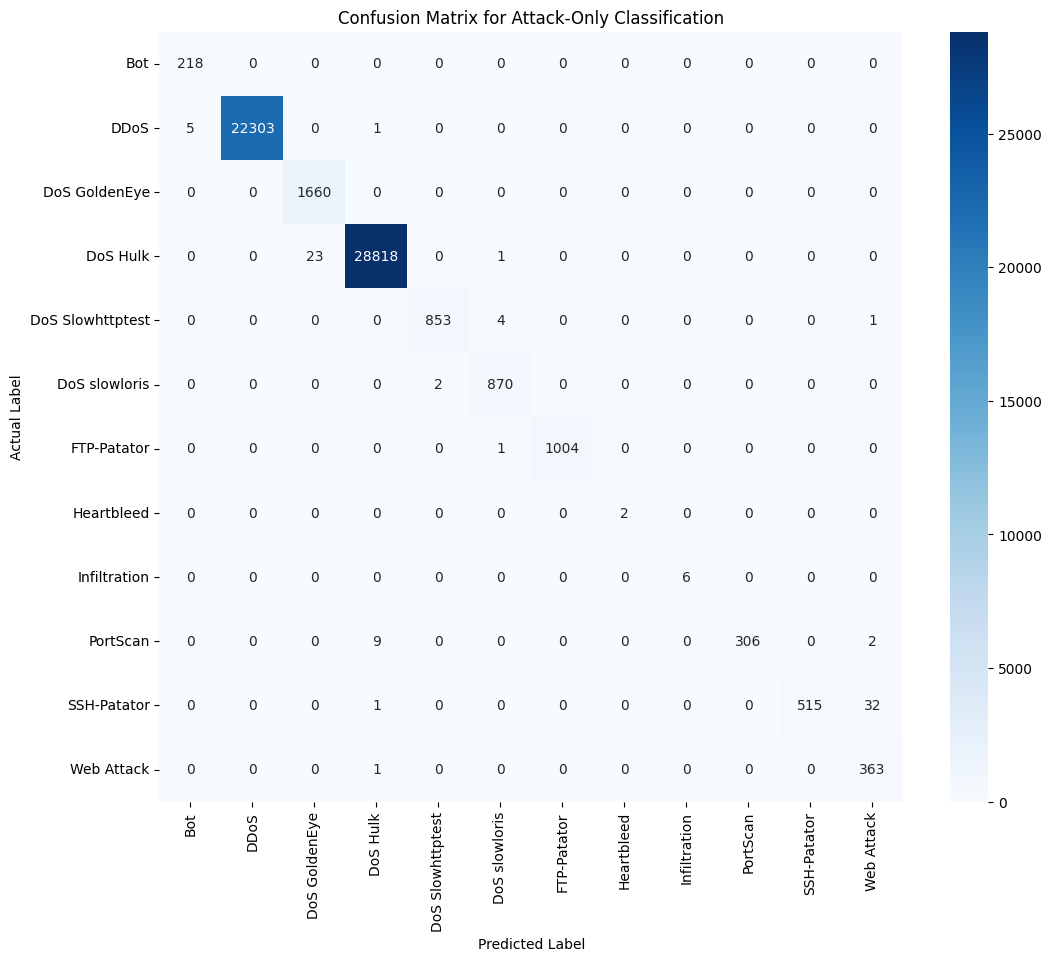

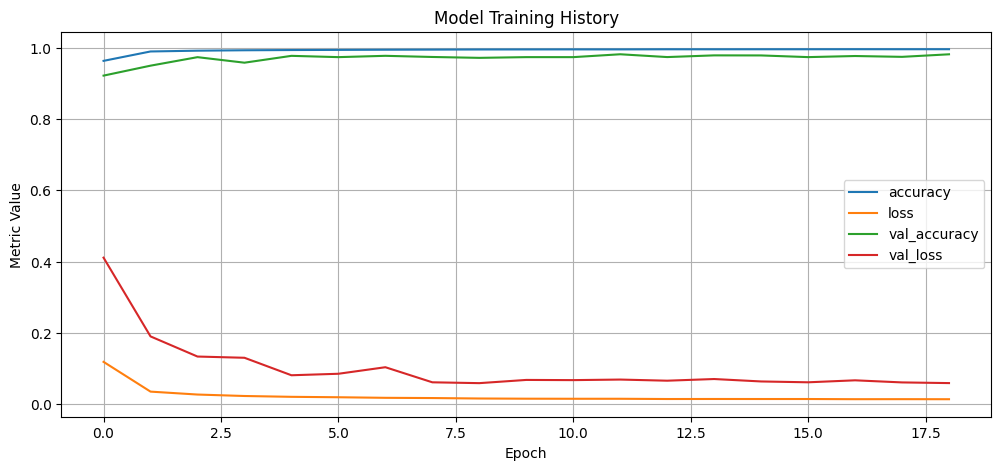

In [ ]:
# --- 8. Evaluating the Attack Classifier ---
print("\n--- Model Evaluation on Test Set ---")
loss, accuracy = model.evaluate(X_test_reshaped, y_test_np, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_proba = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# --- Classification Report ---
# Dynamically handle missing classes in the test set
# Get the unique labels that are actually present in the test set predictions and true labels
present_labels = np.unique(np.concatenate((y_test_np, y_pred_classes)))
# Filter the full list of target names to only include those present in the test set
report_target_names = [name for i, name in enumerate(label_encoder.classes_) if i in present_labels]

print("\n--- Classification Report ---")
# Use the 'labels' and filtered 'target_names' parameters
print(classification_report(
    y_test_np,
    y_pred_classes,
    labels=present_labels,
    target_names=report_target_names,
    zero_division=0,
    digits=5
))


# --- Confusion Matrix ---
cm = confusion_matrix(y_test_np, y_pred_classes, labels=present_labels)
plt.figure(figsize=(12, 10))
# Use the filtered target names for the plot axes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=report_target_names,
            yticklabels=report_target_names)
plt.title('Confusion Matrix for Attack-Only Classification')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Training History ---
pd.DataFrame(history.history).plot(figsize=(12, 5), grid=True)
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.show()